<a href="https://colab.research.google.com/github/MehrdadJalali-AI/InverseLinkPredcition/blob/main/InverseLinkPredcition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before sparsification: 414650 edges, 12561 nodes.
Best combination coefficient (a): 0.8 with modularity: 0.8328034432262569
After sparsification: 1883 edges, 2112 nodes.
Total runtime: 932.9555571079254 seconds
Features of the remaining nodes saved to remaining_node_features_3.csv.


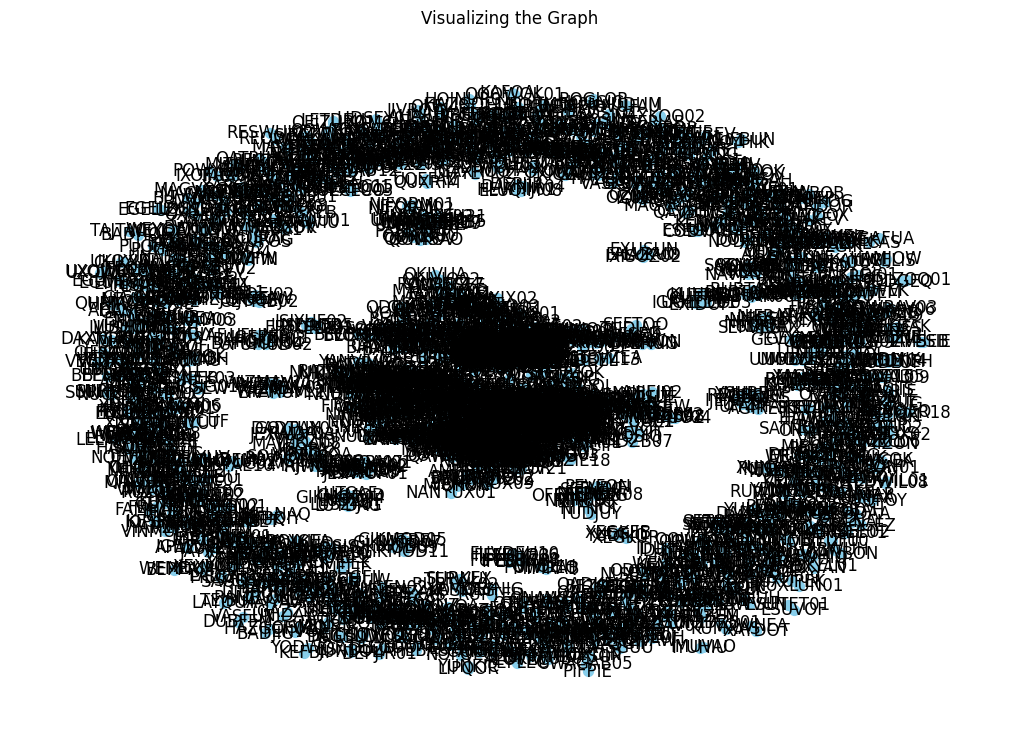

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import networkx.algorithms.community as nx_comm
import time

import warnings
# Suppress RDKit warnings (for potential future use with SMILES)
from rdkit import rdBase
rdBase.DisableLog("rdApp.*")
warnings.filterwarnings("ignore")
def load_edges_list(filename):
    """Loads edge list from a CSV file."""

    return pd.read_csv(filename)

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros((1024,))  # Return an array of zeros if molecule can't be parsed
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,))  # Return an array of zeros in case of an error

def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def load_summary_data(filename, node_labels):
    """Loads summary data and preprocesses it to extract features."""
    summary_data = pd.read_csv(filename, index_col=0)
    linker_smiles = summary_data['linker SMILES']
    linker_features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    metal_names = summary_data['metal']
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
    other_features = summary_data[['Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_features, metal_features, other_features), axis=1)
    # Adjusted part: Use summary_data indices if they're complete and align with node labels
    if len(summary_data) == len(node_labels) and all(label in summary_data.index for label in node_labels):
        return pd.DataFrame(features, index=node_labels)
    else:
        # Handle cases where summary_data and node_labels don't align
        print("Warning: Mismatch between summary data and node labels.")
        return pd.DataFrame(features, index=summary_data.index)

def build_and_compile_model(input_shape):
    """Builds and compiles a neural network model."""
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

def predict_link_importance(model, node_features):
    """Predicts link importance using a trained model."""
    return model.predict(node_features).flatten()

def optimize_combination_for_modularity(graph, features, importance_scores, initial_weights, threshold=0.2):
    """Finds the best combination of importance scores and initial weights for modularity."""
    best_modularity = -1
    best_a = 0.0
    a_range = np.linspace(0, 1, 11)
    for a in a_range:
        combined_scores = a * importance_scores + (1 - a) * initial_weights
        edges_to_remove = [edge for edge, score in zip(graph.edges(), combined_scores) if score < threshold]
        graph_copy = graph.copy()
        graph_copy.remove_edges_from(edges_to_remove)
        communities = nx_comm.greedy_modularity_communities(graph_copy)
        modularity = nx_comm.modularity(graph_copy, communities)
        if modularity > best_modularity:
            best_modularity = modularity
            best_a = a
    print(f"Best combination coefficient (a): {best_a} with modularity: {best_modularity}")
    return best_a

def visualize_graph(graph):
    """Visualizes the graph."""
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
    plt.title("Visualizing the Graph")
    plt.show()



def remove_edges_and_nodes(graph, importance_scores, initial_weights, best_a, threshold):
    combined_scores = best_a * importance_scores + (1 - best_a) * initial_weights
    edges_to_remove = [(u, v) for (u, v, data), score in zip(graph.edges(data=True), combined_scores) if score < threshold]
    graph.remove_edges_from(edges_to_remove)

    # Remove nodes with degree zero
    isolated_nodes = list(nx.isolates(graph))
    graph.remove_nodes_from(isolated_nodes)
    return graph

def save_remaining_node_features(graph, summary_data, filename):
    remaining_nodes = list(graph.nodes())
    remaining_features = summary_data.loc[remaining_nodes]
    remaining_features.to_csv(filename, index=False)  # Assuming the index is not needed
    print(f"Features of the remaining nodes saved to {filename}.")

if __name__ == "__main__":
    start_time = time.time()
    edges_list_filename = 'edges_list_0.8_Full_2.csv'
    summary_data_filename = '1M1L3D_summary.csv'
    output_edges_filename = 'sparsified_graph_edges_0.98.csv'
    output_features_filename = 'remaining_node_features_3.csv'

    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()
    summary_data = load_summary_data(summary_data_filename, node_labels)

    # Construct the graph
    graph = nx.Graph()
    for _, row in edges_list.iterrows():
        graph.add_edge(row['source'], row['target'], weight=row['weight'])

    # Print number of edges and nodes before sparsification
    print(f"Before sparsification: {graph.number_of_edges()} edges, {graph.number_of_nodes()} nodes.")

    # Generate and prepare node features
    node_features = np.array([summary_data.loc[node].values for node in graph.nodes()])
    scaler = StandardScaler()
    node_features_scaled = scaler.fit_transform(node_features)

    # Initialize and train your model here. Placeholder values are used as an example.
    model = build_and_compile_model(node_features_scaled.shape[1])
    # Model training code should go here

    # Dummy importance scores and initial weights for demonstration purposes
    importance_scores = np.random.rand(len(graph.edges()))
    initial_weights = np.array([data['weight'] for _, _, data in graph.edges(data=True)])

    best_a = optimize_combination_for_modularity(graph, summary_data, importance_scores, initial_weights)
    graph = remove_edges_and_nodes(graph, importance_scores, initial_weights, best_a, 0.98)

    # Save the sparsified edge list
    nx.write_edgelist(graph, output_edges_filename, data=['weight'])
    # Print number of edges and nodes after sparsification

  # Print number of edges and nodes after sparsification
    print(f"After sparsification: {graph.number_of_edges()} edges, {graph.number_of_nodes()} nodes.")
    print(f"Total runtime: {time.time() - start_time} seconds")
    save_remaining_node_features(graph, summary_data, output_features_filename)
    visualize_graph(graph)




In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import time
import warnings
import networkx.algorithms.community as nx_comm

# Suppress warnings
warnings.filterwarnings("ignore")

def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    return pd.read_csv(filename)

def approximate_edge_betweenness(graph, k=1000):
    """Approximates edge betweenness centrality by sampling k nodes."""
    nodes = list(graph.nodes())
    if len(nodes) <= k:
        return nx.edge_betweenness_centrality(graph, weight='weight')
    sampled_nodes = np.random.choice(nodes, k, replace=False)
    edge_scores = nx.edge_betweenness_centrality_subset(graph, sources=sampled_nodes, targets=sampled_nodes, weight='weight')
    return edge_scores

def edge_betweenness_sparsification(graph, edge_reduction_target):
    """Sparsifies the graph using edge betweenness centrality to achieve a target edge reduction percentage."""
    edge_scores = approximate_edge_betweenness(graph, k=1000)
    sorted_edges = sorted(edge_scores.items(), key=lambda x: x[1], reverse=True)
    sparsification_ratio = 1 - (edge_reduction_target / 100)  # Convert percentage to fraction of edges to keep
    num_edges_to_keep = int(len(sorted_edges) * sparsification_ratio)
    edges_to_keep = sorted_edges[:num_edges_to_keep]
    g_sparsified = graph.copy()
    edges_to_remove = [edge for edge, _ in sorted_edges[num_edges_to_keep:]]
    g_sparsified.remove_edges_from(edges_to_remove)
    isolated_nodes = list(nx.isolates(g_sparsified))
    g_sparsified.remove_nodes_from(isolated_nodes)
    return g_sparsified

def compute_metrics(graph, original_edges, original_nodes):
    """Computes metrics for a sparsified graph."""
    if graph.number_of_edges() == 0:
        return 0, 0, 0, 0
    communities = nx_comm.greedy_modularity_communities(graph)
    modularity = nx_comm.modularity(graph, communities)
    diameter = nx.diameter(graph) if nx.is_connected(graph) else float('inf')
    edge_reduction = (original_edges - graph.number_of_edges()) / original_edges * 100 if original_edges > 0 else 0
    node_reduction = (original_nodes - graph.number_of_nodes()) / original_nodes * 100
    return modularity, diameter, edge_reduction, node_reduction

def compare_baseline_methods(graph, edge_reduction_targets=[87.1, 94.2, 97.3]):
    """Compares edge betweenness centrality at given edge reduction targets."""
    results = []
    original_edges = graph.number_of_edges()
    original_nodes = graph.number_of_nodes()

    for edge_reduction_target in edge_reduction_targets:
        # Edge Betweenness Centrality Sparsification
        start_time = time.time()
        g_betweenness = edge_betweenness_sparsification(graph, edge_reduction_target)
        betweenness_time = time.time() - start_time
        modularity_betweenness, diameter_betweenness, edge_reduction_betweenness, node_reduction_betweenness = compute_metrics(g_betweenness, original_edges, original_nodes)

        results.append({
            'Method': 'Edge Betweenness',
            'Edge Reduction Target (%)': edge_reduction_target,
            'Runtime (s)': betweenness_time,
            'Modularity': modularity_betweenness,
            'Network Diameter': diameter_betweenness,
            'Edge Reduction Achieved (%)': edge_reduction_betweenness,
            'Node Reduction (%)': node_reduction_betweenness,
            'Nodes': g_betweenness.number_of_nodes(),
            'Edges': g_betweenness.number_of_edges()
        })

    # Convert to DataFrame and print
    results_df = pd.DataFrame(results)
    print("\nEdge Betweenness Centrality Sparsification Results:")
    print(results_df)
    results_df.to_csv('baseline_sparsification_comparison.csv', index=False)

    return results_df

if __name__ == "__main__":
    start_time = time.time()
    edges_list_filename = 'edges_list_0.8_Full_2.csv'

    # Load data
    edges_list = load_edges_list(edges_list_filename)

    # Construct the graph
    graph = nx.Graph()
    for _, row in edges_list.iterrows():
        graph.add_edge(row['source'], row['target'], weight=row['weight'])
    print(f"Before sparsification: {graph.number_of_edges()} edges, {graph.number_of_nodes()} nodes.")

    # Compare baseline methods at edge reduction targets matching ILP
    edge_reduction_targets = [87.1, 94.2, 97.3]  # Match ILP results
    results_df = compare_baseline_methods(graph, edge_reduction_targets)

    print(f"Total runtime: {time.time() - start_time:.2f} seconds")

Before sparsification: 414650 edges, 12561 nodes.

Edge Betweenness Centrality Sparsification Results:
             Method  Edge Reduction Target (%)  Runtime (s)  Modularity  \
0  Edge Betweenness                       87.1    59.750332    0.649071   
1  Edge Betweenness                       94.2    62.018097    0.658283   
2  Edge Betweenness                       97.3    57.531121    0.818934   

   Network Diameter  Edge Reduction Achieved (%)  Node Reduction (%)  Nodes  \
0               inf                    87.100205           74.253642   3234   
1               inf                    94.200169           78.011305   2762   
2               inf                    97.300133           79.906058   2524   

   Edges  
0  53489  
1  24049  
2  11195  
Total runtime: 224.09 seconds


In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 8.3 MB/s eta 0:00:00


In [2]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/InverseLinkPredcition')

Mounted at /content/drive
